## Sedinet: predict 9 percentiles of the grain size distribution from a large population of 400 images

This Jupyter notebook accompanies the [SediNet](https://github.com/MARDAScience/SediNet) package

Written by Daniel Buscombe, MARDA Science

daniel@mardascience.com


> Demonstration of how to use SediNet to estimate from an ensemble of three models to estimate nine percentiles of the cumulative grain size distribution from a larger population of sands and gravels and mixtures from all over the world

First, this notebbok assumes you are a cloud computer such as Colab so we first download the SediNet package from github:


In [1]:
!git clone --depth 1 https://github.com/MARDAScience/SediNet.git

Cloning into 'SediNet'...
remote: Enumerating objects: 760, done.
remote: Counting objects: 100% (760/760), done.
remote: Compressing objects: 100% (688/688), done.
remote: Total 760 (delta 87), reused 716 (delta 68), pack-reused 0
Receiving objects: 100% (760/760), 1.11 GiB | 15.78 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Checking out files: 100% (725/725), done.


In [2]:
import os, json
os.chdir('SediNet')

Import everything we need from sedinet_models.py

In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [4]:
from sedinet_eval import *
from numpy import any as npany

In [5]:
configfile = 'config/config_9percentiles_predict.json'
weights_path = 'grain_size_global/res/grey/global_9prcs_simo_batch8_P10_P16_P25_P5_P50_P75_P84_P90_P95__checkpoint.hdf5'

Load the config file and parse out the variables we need

In [6]:
try:
    # load the user configs
    with open(os.getcwd()+os.sep+configfile) as f:
       config = json.load(f)
except:
    # load the user configs
    with open(configfile) as f:
       config = json.load(f)    
    
###===================================================
## user defined variables: proportion of data to use for training (a.k.a. the "train/test split")
csvfile = config["csvfile"] #csvfile containing image names and class values
res_folder = config["res_folder"] #folder containing csv file and that will contain model outputs
name = config["name"] #name prefix for output files
greyscale = config["greyscale"] #convert imagery to greyscale or not
dropout = config["dropout"] 

try:
   numclass = config['numclass']
except:
   numclass = 0
        
vars = [k for k in config.keys() if not npany([k.startswith('csvfile'), k.startswith('dropout'), k.startswith('base'), k.startswith('res_folder'), k.startswith('train_csvfile'), k.startswith('test_csvfile'), k.startswith('name'), k.startswith('greyscale'), k.startswith('aux_in'), k.startswith('N'), k.startswith('numclass')])]

vars = sorted(vars)

csvfile = res_folder+os.sep+csvfile

This next part reads the data in from the csv file as a pandas dataframe, gets an image generator, and then prepares three models with different base values

In [7]:
df = pd.read_csv(csvfile)
df['files'] = [k.strip() for k in df['files']]

train_idx = np.arange(len(df))

CS = joblib.load(weights_path.replace('.hdf5','_scaler.pkl')) 

varstring = ''.join([str(k)+'_' for k in vars])
      
##==============================================
## create a sedinet model to estimate category
model = make_sedinet_siso_simo(vars, greyscale, dropout) 
model.load_weights(os.getcwd()+os.sep+weights_path)

Z = joblib.load(weights_path.replace('.hdf5','_bias.pkl'))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[INFORMATION] Model summary:


In [8]:
train_gen = get_data_generator_Nvars_siso_simo(df, train_idx, False, vars, len(df), greyscale, CS)

#df['files'] = [os.getcwd()+os.sep+f.replace('\\',os.sep) for f in df['files']]
#train_gen = get_data_generator_Nvars_siso_simo(df, train_idx, False, vars, len(df), greyscale, CS) #   
#x_train, tmp = next(train_gen)

x_train, tmp = next(train_gen)
if len(vars)>1:
   counter = 0
   for v in vars:
      exec(v+'_trueT = np.squeeze(CS[counter].inverse_transform(tmp[counter].reshape(-1,1)))')
      counter +=1
else:
   exec(vars[0]+'_trueT = np.squeeze(CS[0].inverse_transform(tmp[0].reshape(-1,1)))')
         
if len(vars)>1:
   counter = 0
   for v in vars:
      exec(v+'_trueT = np.squeeze(CS[counter].inverse_transform(tmp[counter].reshape(-1,1)))')
      counter +=1
else:
   exec(vars[0]+'_trueT = np.squeeze(CS[0].inverse_transform(tmp[0].reshape(-1,1)))')

Now the models are set up, we use them below to make predictions on each image so we end up with three estimates per image, and our final estimate is their mean

In [9]:
for v in vars:
    exec(v+'_PT = []')

tmp = model.predict(x_train, batch_size=1)

if len(vars)>1:
    counter = 0
    for v in vars:
       exec(v+'_PT.append(np.squeeze(CS[counter].inverse_transform(tmp[counter].reshape(-1,1))))')
       counter +=1
else:
    exec(vars[0]+'_PT.append(np.asarray(np.squeeze(CS[0].inverse_transform(tmp.reshape(-1,1)))))') 

In [10]:
if len(vars)>1:
    for k in range(len(vars)):
       exec(vars[k]+'_predT = np.squeeze(np.mean(np.asarray('+vars[k]+'_PT), axis=0))')
else:
    exec(vars[0]+'_predT = np.squeeze(np.mean(np.asarray('+vars[0]+'_PT), axis=0))')

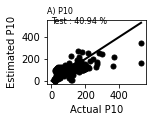

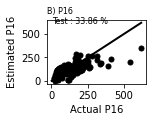

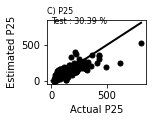

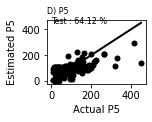

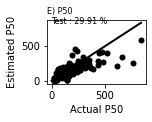

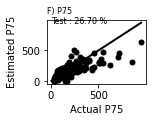

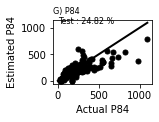

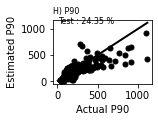

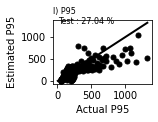

In [11]:
if len(vars)==9:
   nrows = 3; ncols = 3
elif len(vars)==8:
   nrows = 4; ncols = 2
elif len(vars)==7:
   nrows = 3; ncols = 3
elif len(vars)==6:
   nrows = 3; ncols = 2
elif len(vars)==5:
   nrows = 3; ncols = 2
elif len(vars)==4:
   nrows = 2; ncols = 2
elif len(vars)==3:
   nrows = 1; ncols = 3
elif len(vars)==2:
   nrows = 2; ncols = 1
elif len(vars)==1:
   nrows = 1; ncols = 1

## make a plot
fig = plt.figure()
labs = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for k in range(1,1+(nrows*ncols)):
   #try:
   plt.subplot(nrows,ncols,k)
   x = eval(vars[k-1]+'_trueT')
   y = eval(vars[k-1]+'_predT')
   y = np.polyval(Z[k-1],y) #apply bias correction
   y = np.abs(y) #make sure no negative values

   plt.plot(x, y, 'ko', markersize=5)

   plt.plot([ np.min(np.hstack((x,y))),  np.max(np.hstack((x,y)))], [ np.min(np.hstack((x,y))),  np.max(np.hstack((x,y)))], 'k', lw=2)

   plt.text(1.02*np.min(np.hstack((x,y))), 0.98*np.max(np.hstack((x,y))),'Test : '+str(np.mean(100*(np.abs(eval(vars[k-1]+'_predT') - eval(vars[k-1]+'_trueT')) / eval(vars[k-1]+'_trueT'))))[:5]+' %', fontsize=8)

   plt.title(r''+labs[k-1]+') '+vars[k-1], fontsize=8, loc='left')
   plt.xlabel('Actual '+vars[k-1])
   plt.ylabel('Estimated '+vars[k-1])
      
   plt.show()
